In [355]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = ['blue' , 'orange' , 'red' , 'yellow' , 'green'])
plt.rcParams['figure.figsize'] = (40 , 10)
plt.rcParams['font.size'] = 30

In [356]:
# !gdown 1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg --output ../data/mobileSales.xlsx

In [357]:
df = pd.read_excel('../data/mobileSales.xlsx')
df.columns = ['date' , 'sales']
df.set_index('date' , inplace = True)
df.head()

,sales
date,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0


## plot the time series:


<Axes: xlabel='date'>

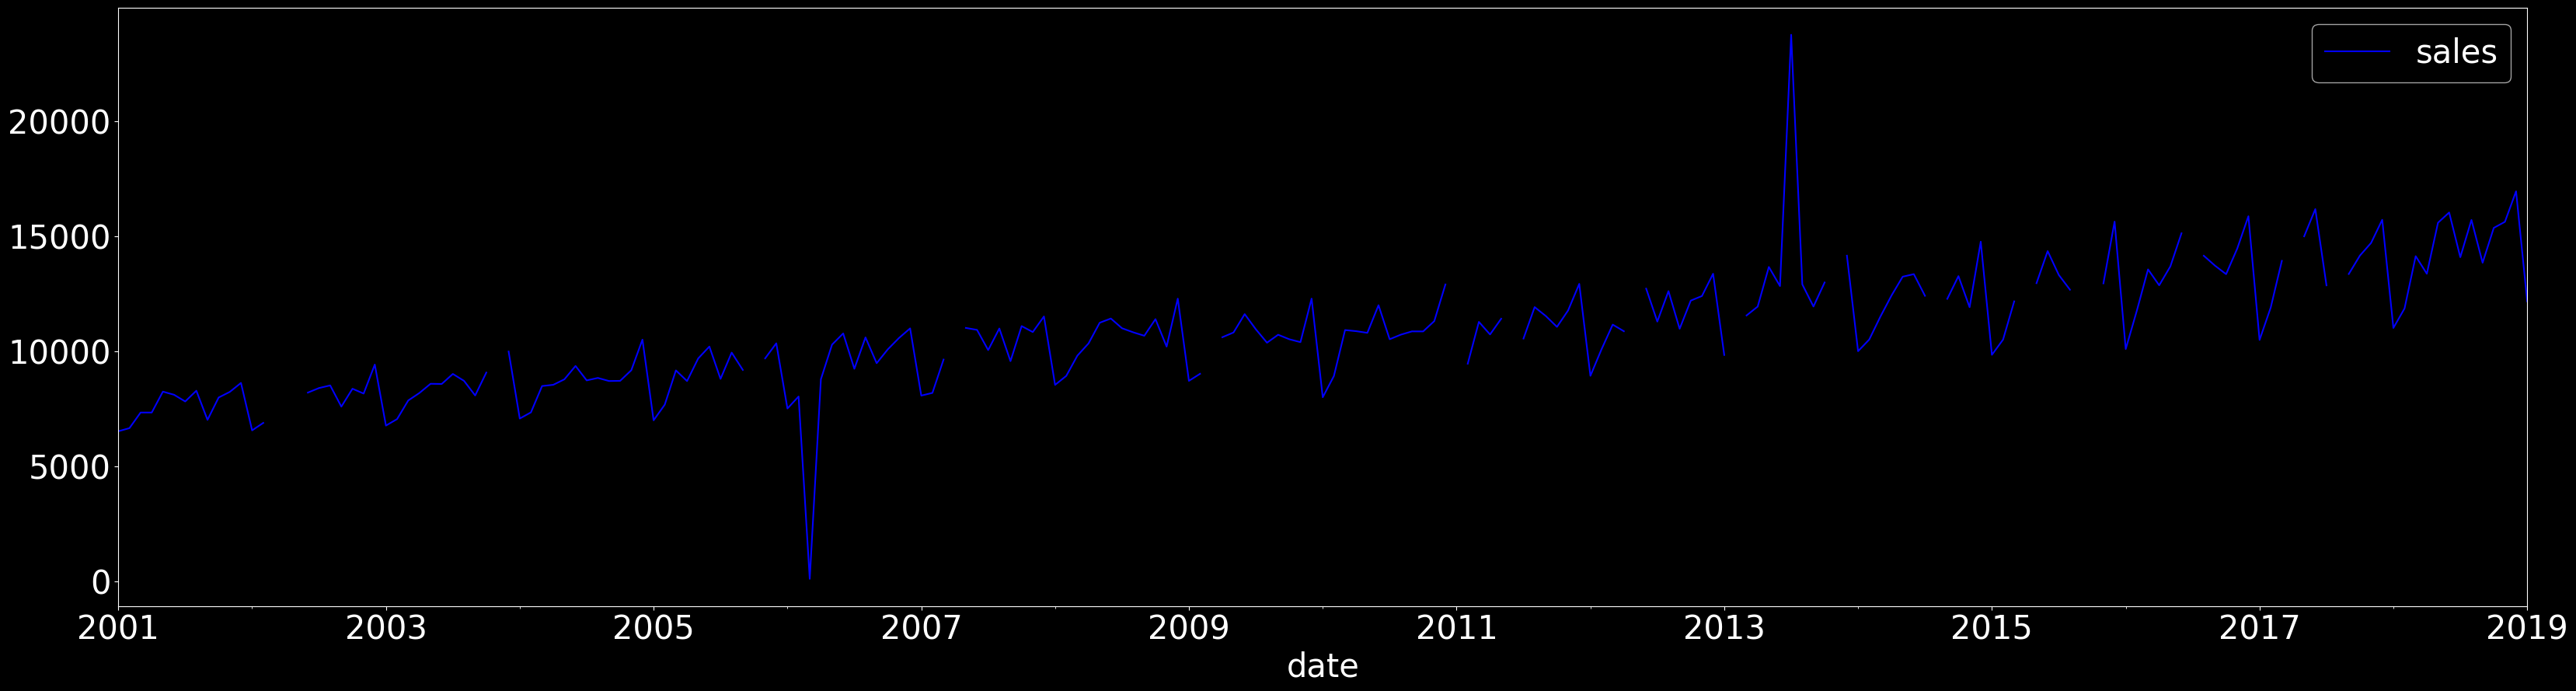

In [358]:
df.plot()

## replace missing data with local mean:


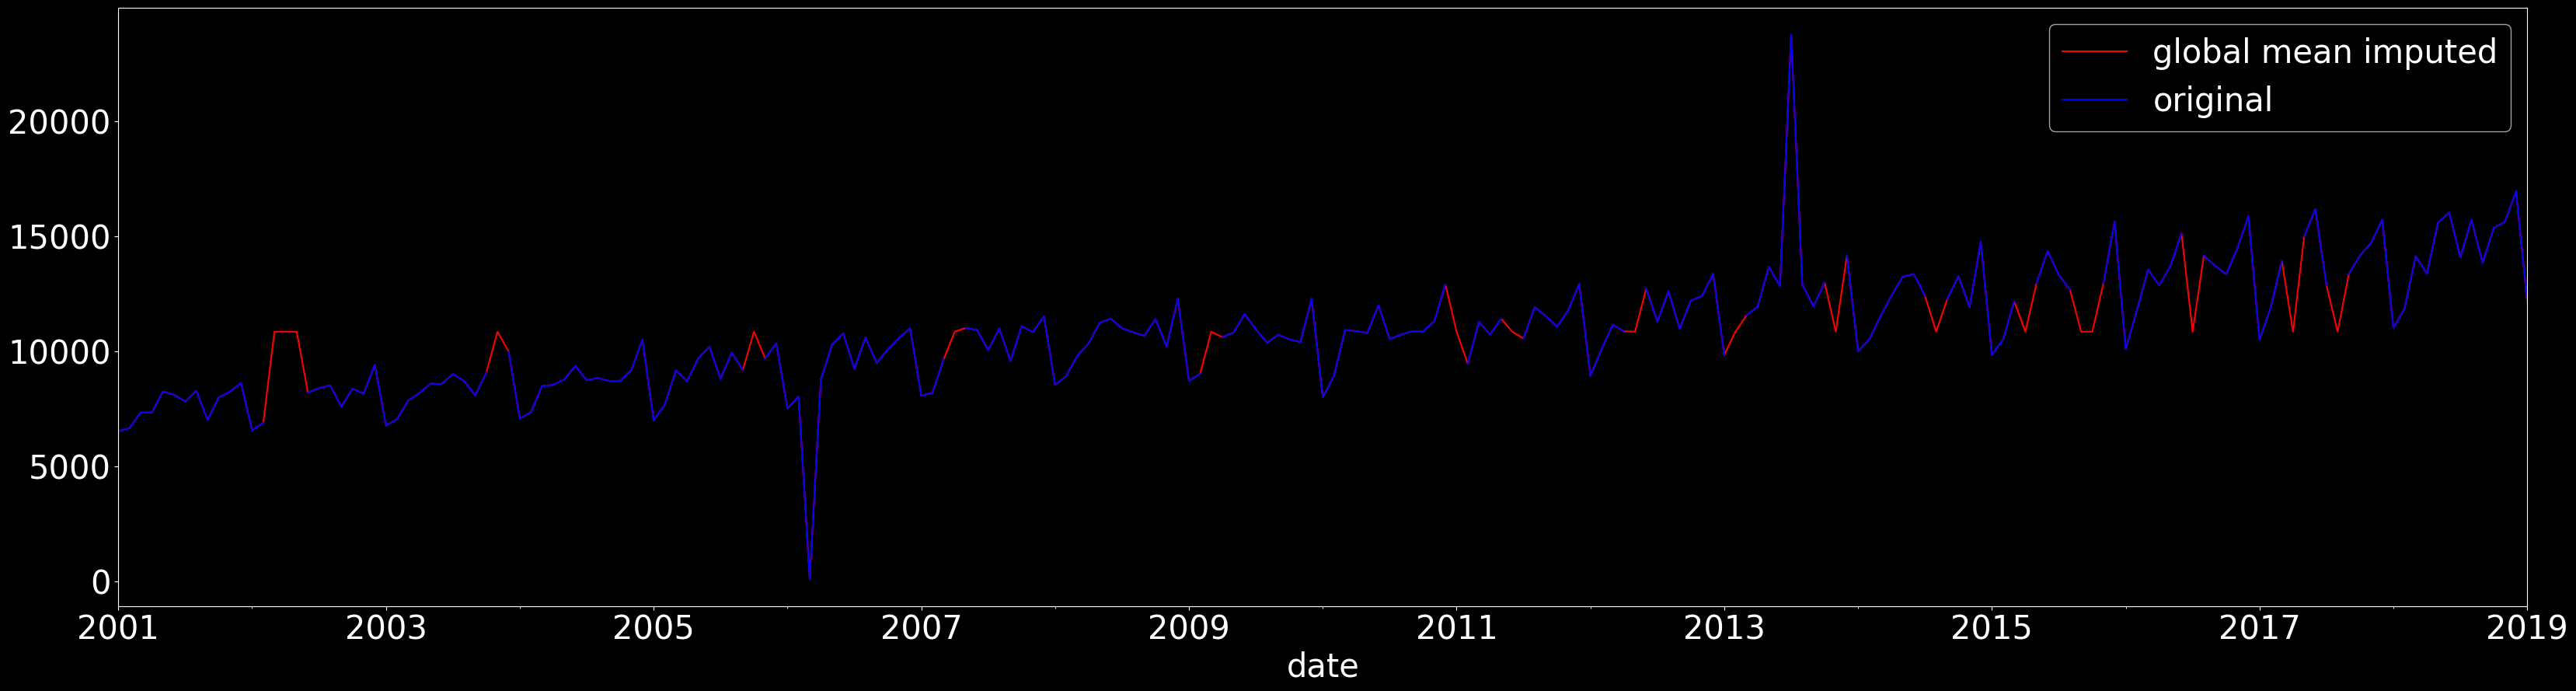

In [359]:
# replace with global mean:
df.sales.fillna(df.sales.mean()).plot(label = 'global mean imputed' , color = 'red')
df.sales.plot(label = 'original')
plt.legend()

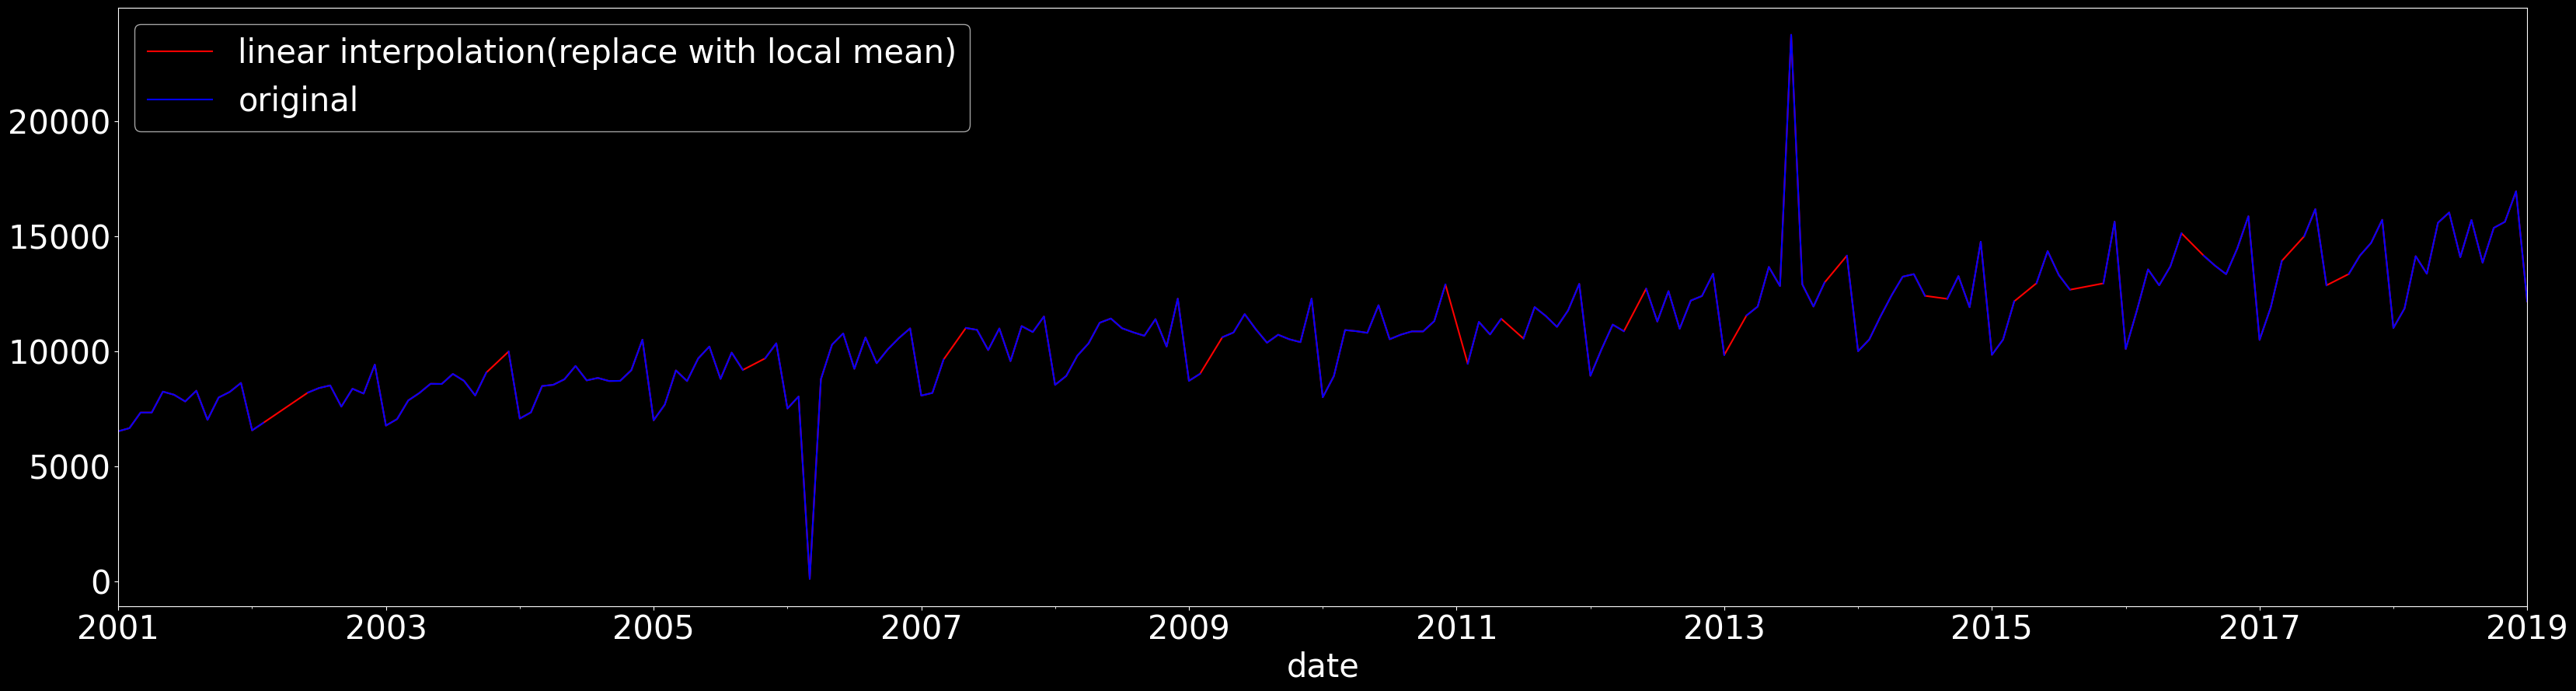

In [360]:
# replace with local mean:
df.sales.interpolate(method = 'linear').plot( label = 'linear interpolation(replace with local mean)' , color = 'red')
df.sales.plot(label = 'original')
plt.legend()
df.sales = df.sales.interpolate(method = 'linear')

## removing anomalies:


[]

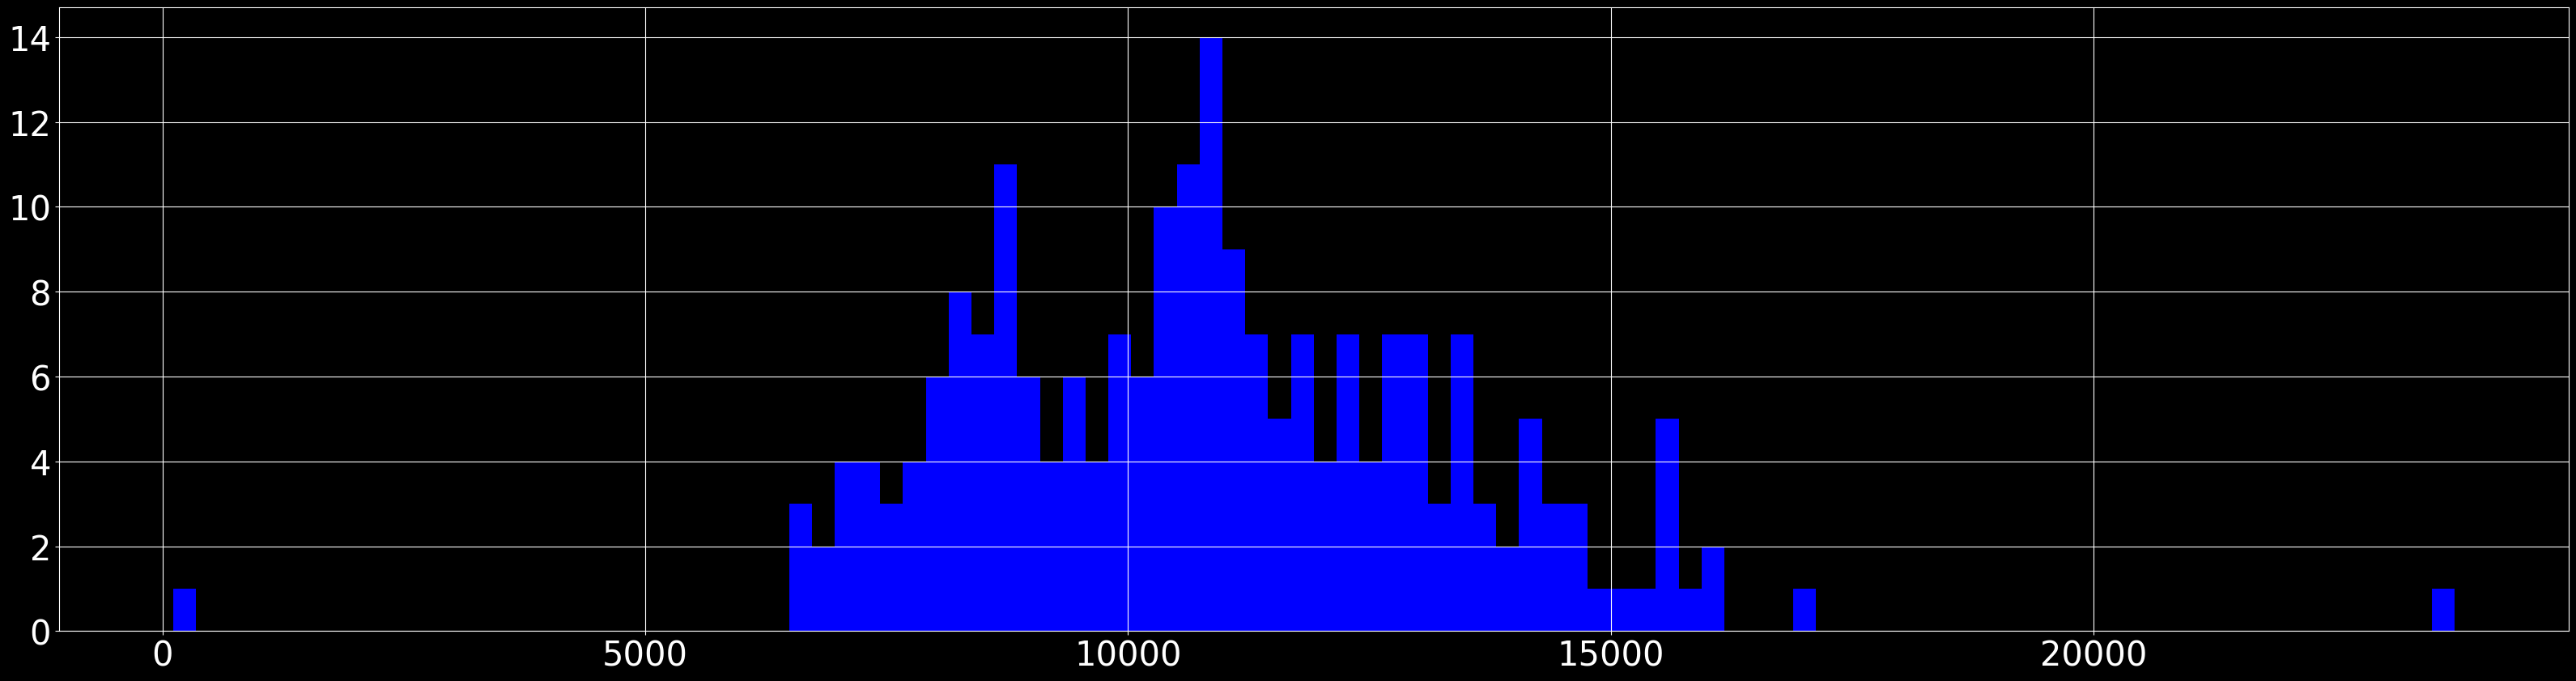

In [361]:
df.sales.hist(bins = 100).plot()

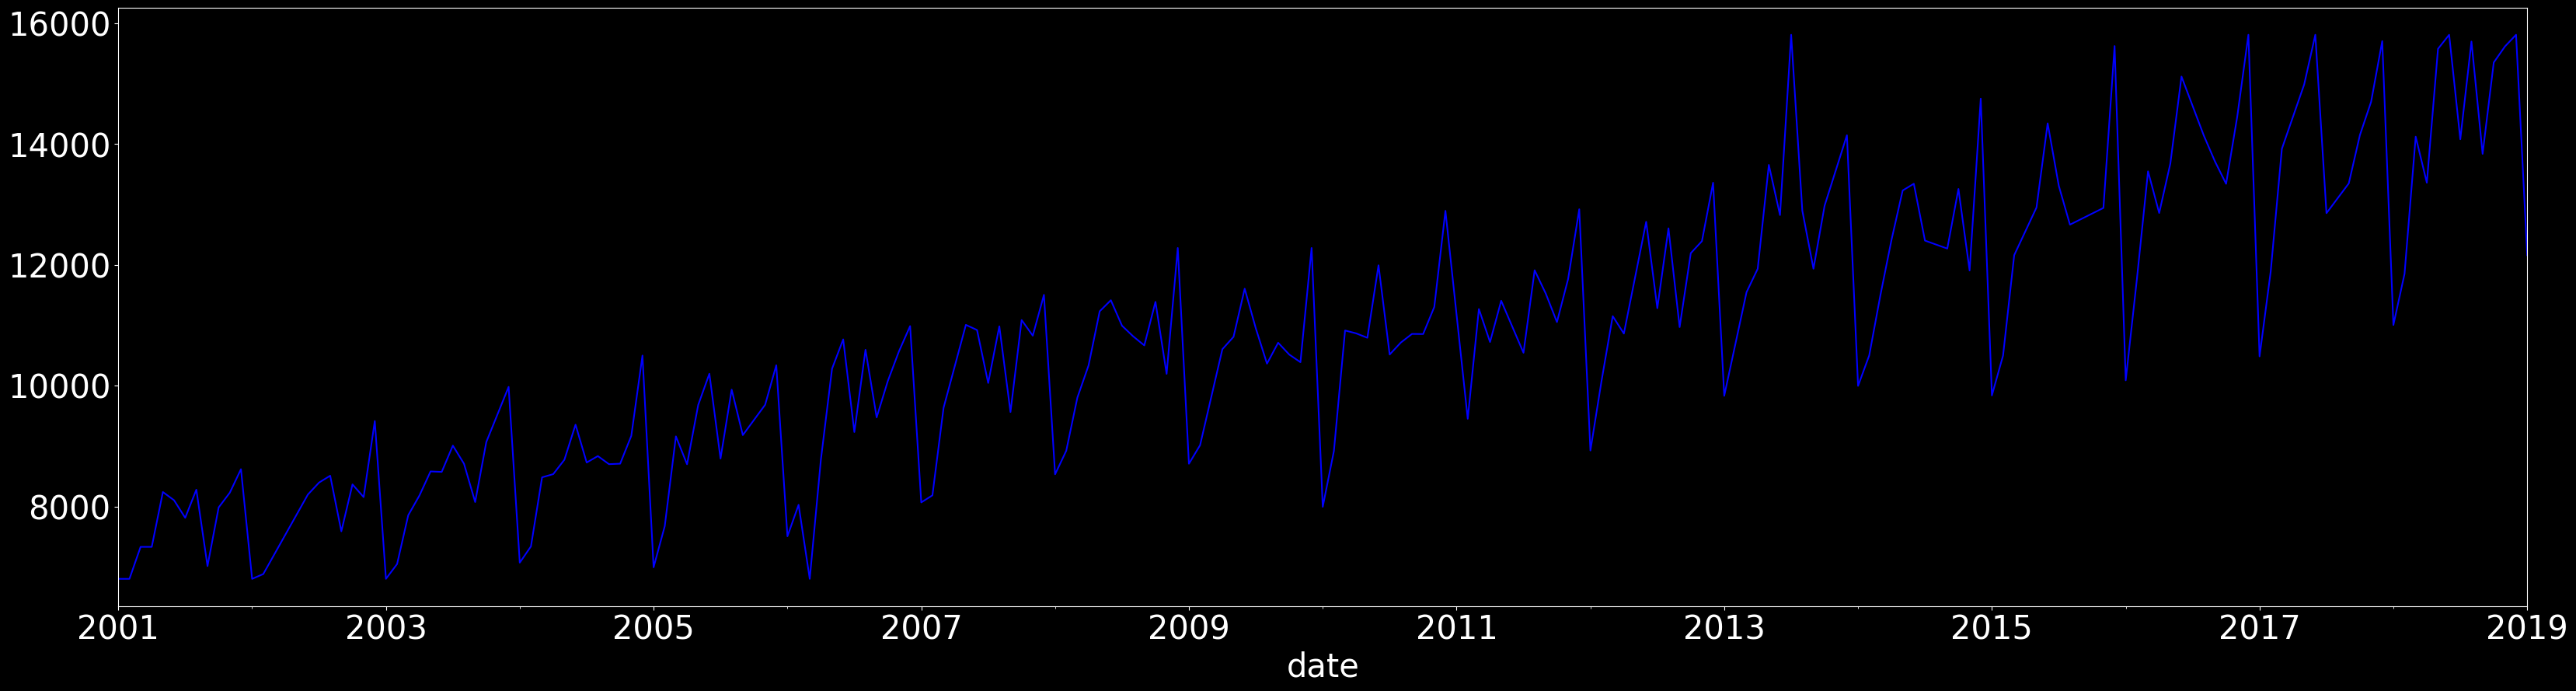

In [362]:
# clip the series to remove sudden peaks:
df.sales.clip(upper = df.sales.quantile(0.02) , lower = df.sales.quantile(0.98)).plot()
df.sales = df.sales.clip(upper = df.sales.quantile(0.02) , lower = df.sales.quantile(0.98))

## time series decomposition:


<Axes: xlabel='date'>

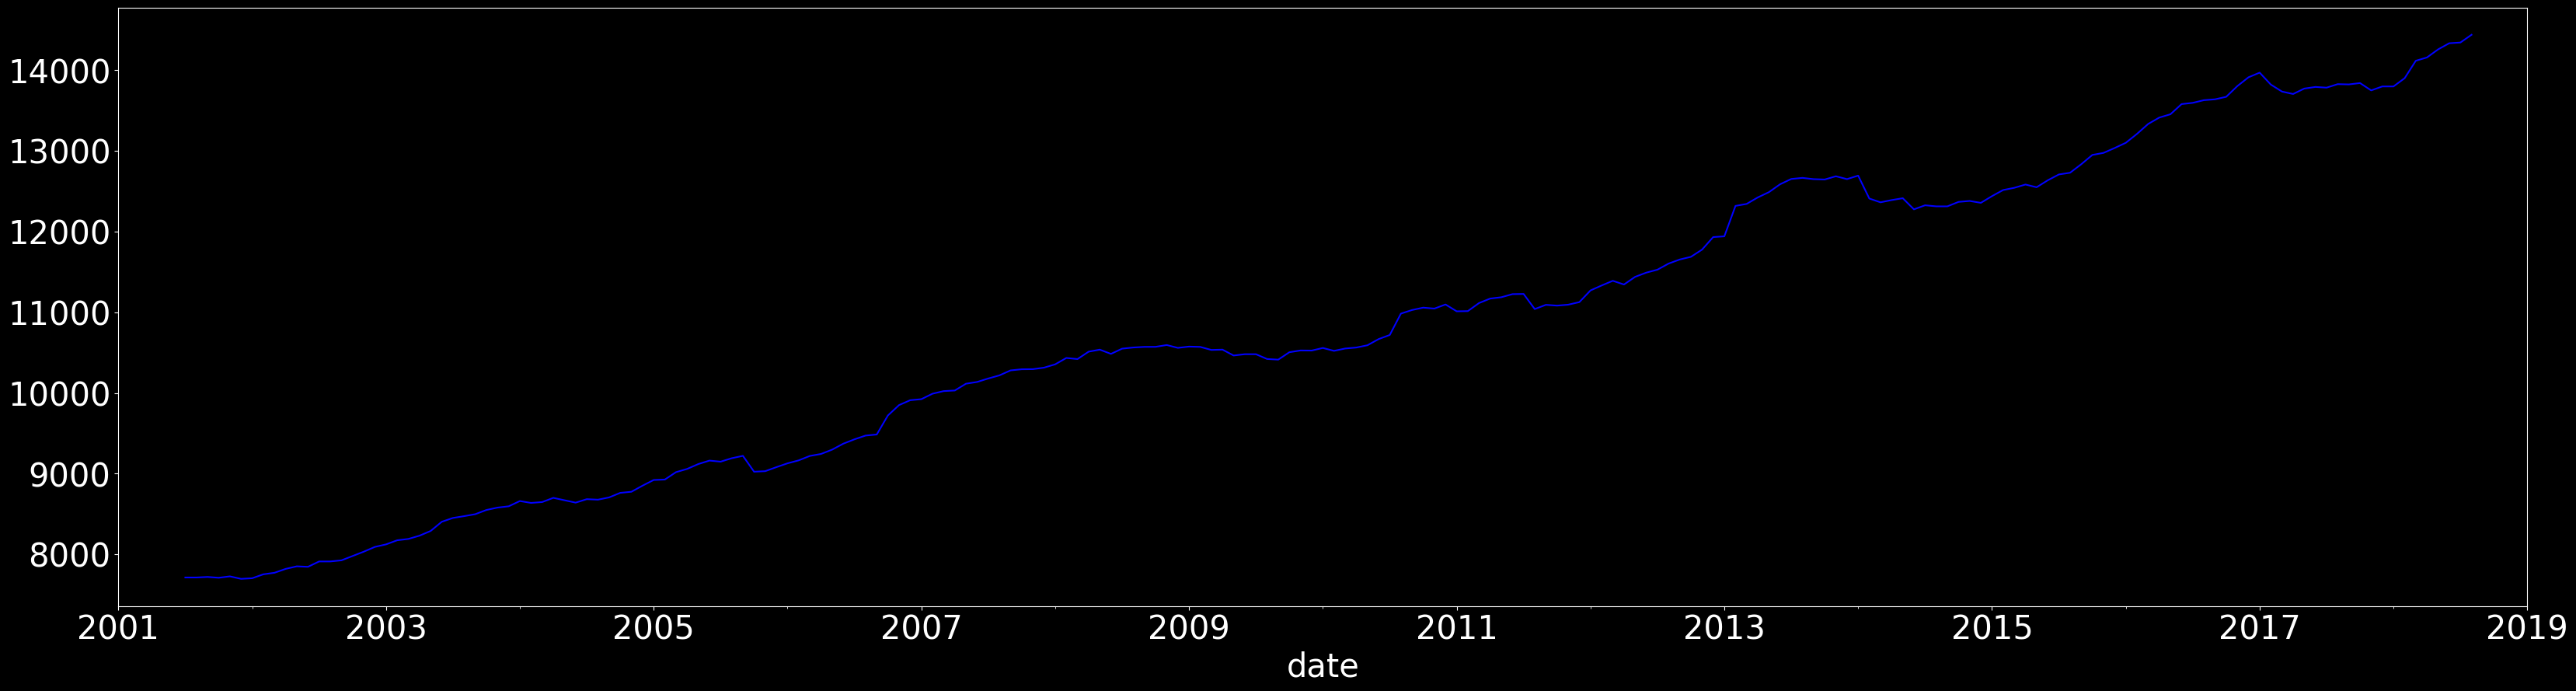

In [363]:
# get the trend line of the data:
trend = df.sales.rolling(12 , center = True).mean()
trend.plot()

<Axes: xlabel='date'>

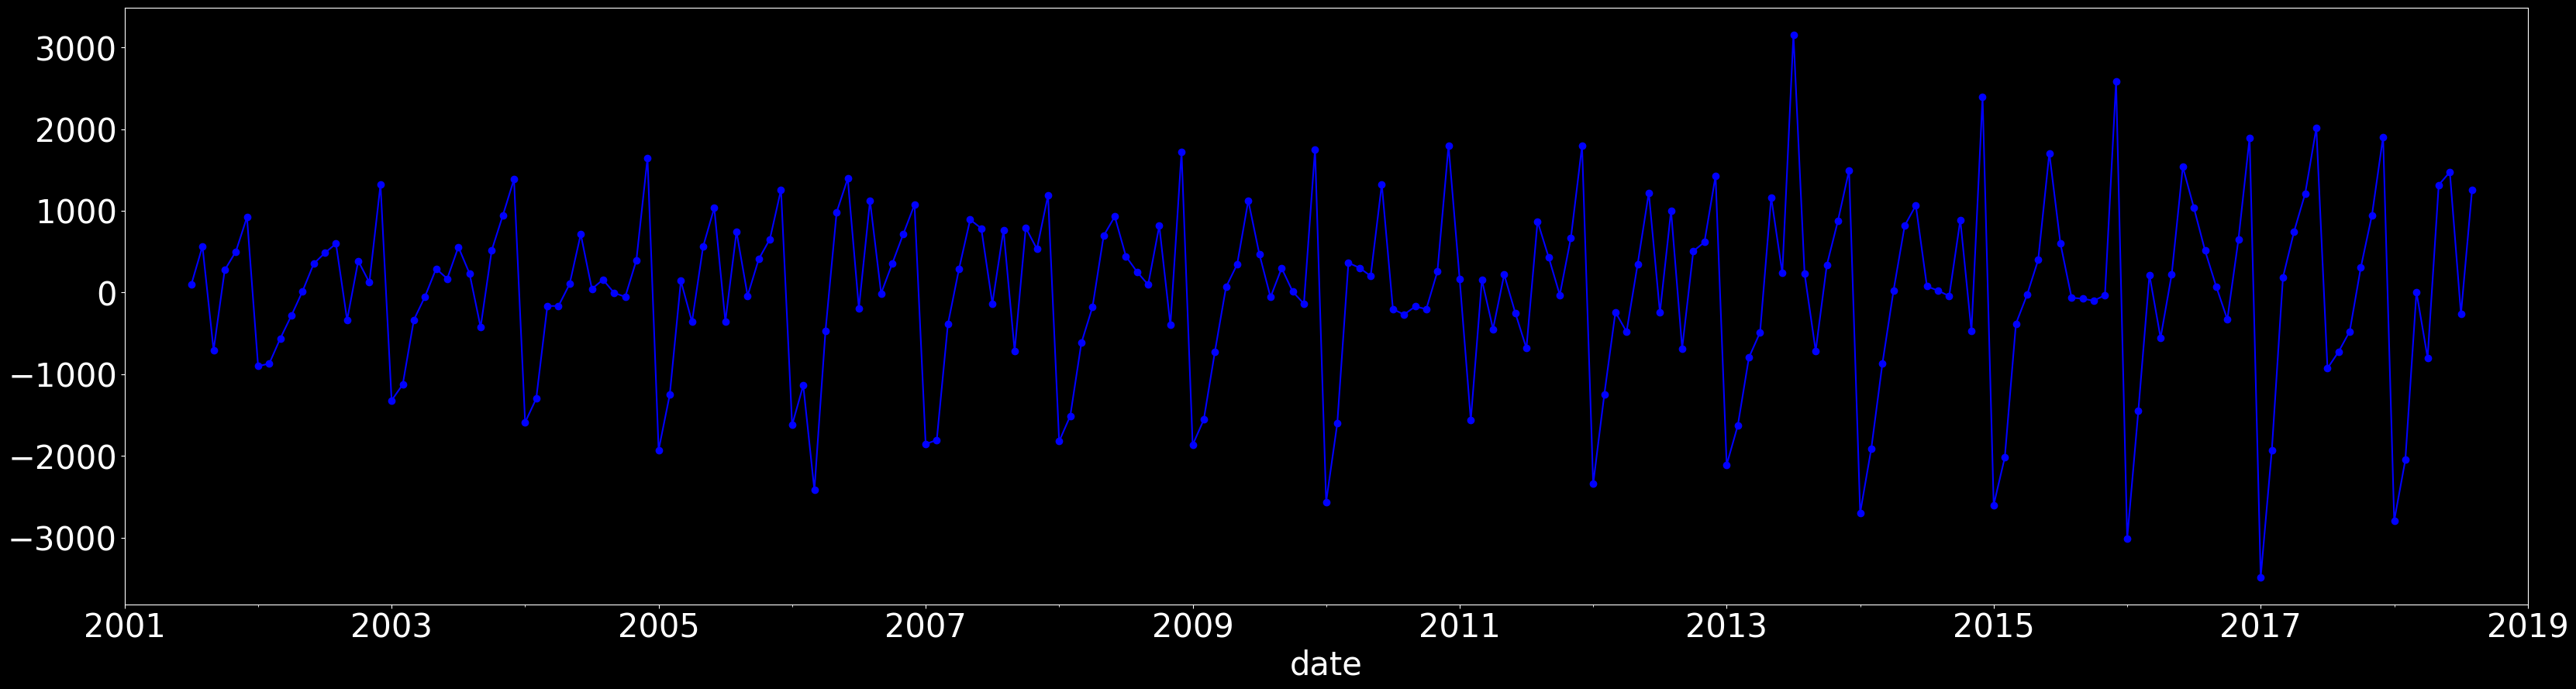

In [364]:
detrend = df.sales - trend
detrend.plot(style = '-o')

<Axes: xlabel='date'>

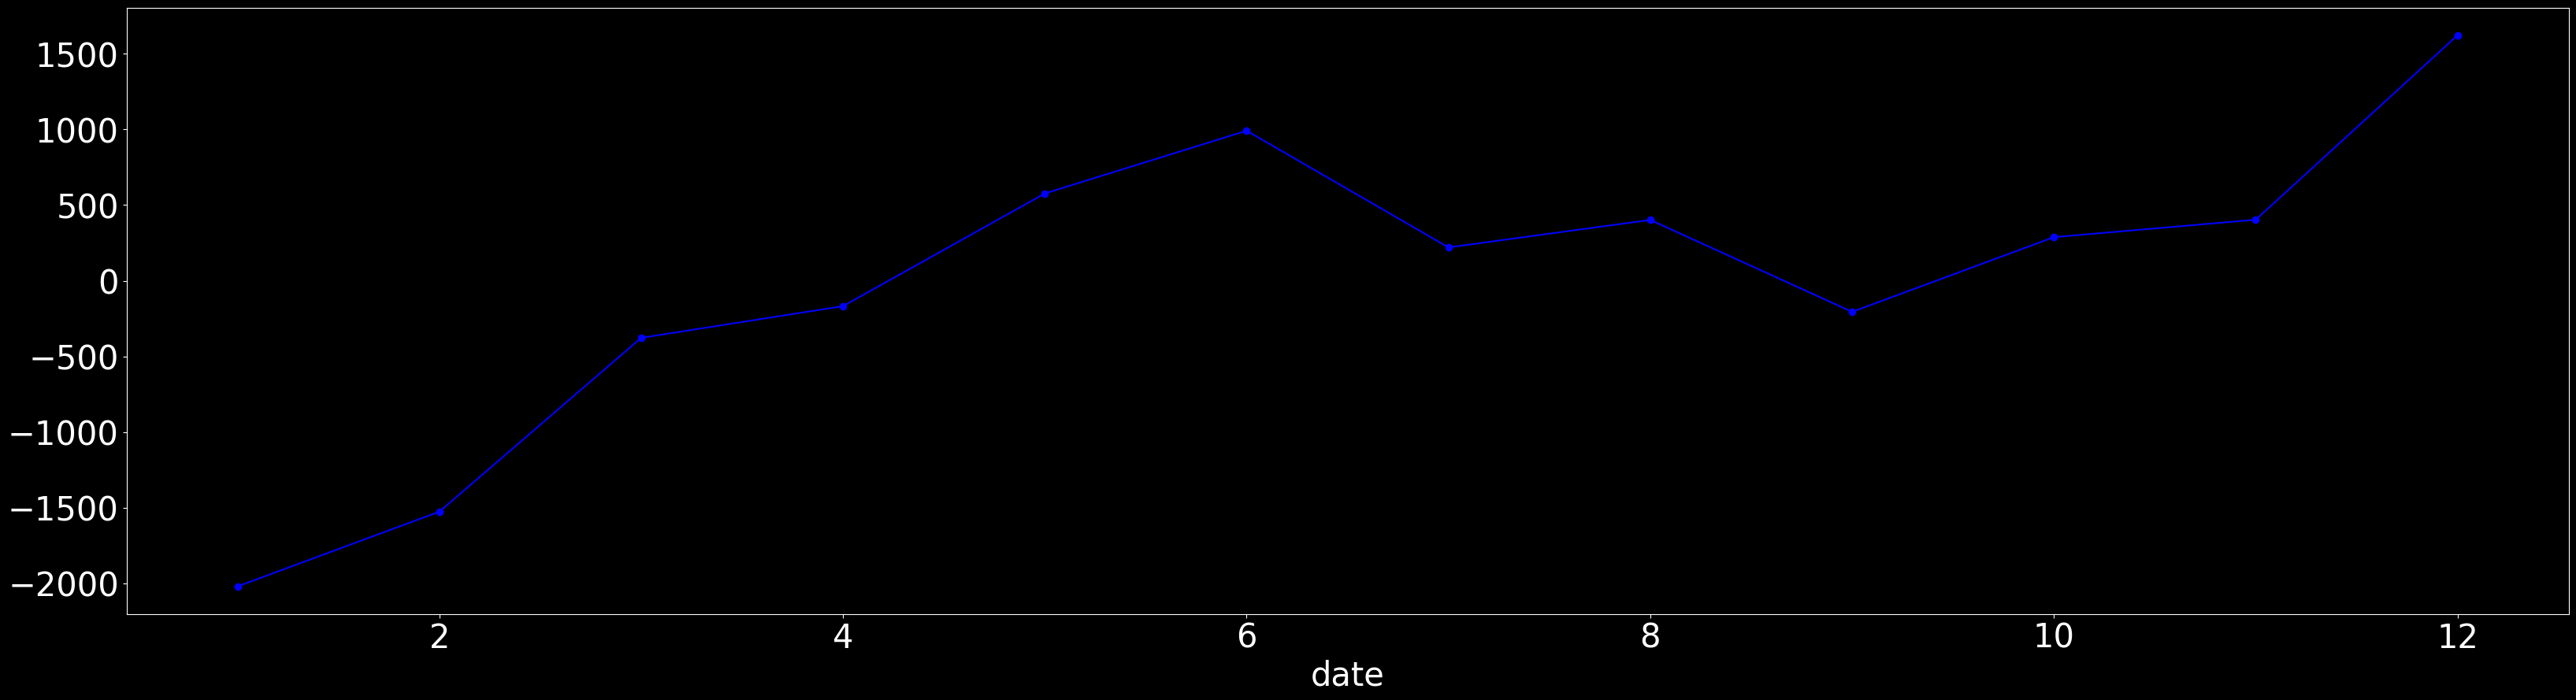

In [365]:
# get monthly sales means from de-trended(seasonality and error) data:
dtdf = detrend.reset_index()
dtdf.groupby(dtdf.date.dt.month)['sales'].mean().plot(  style = '-o')

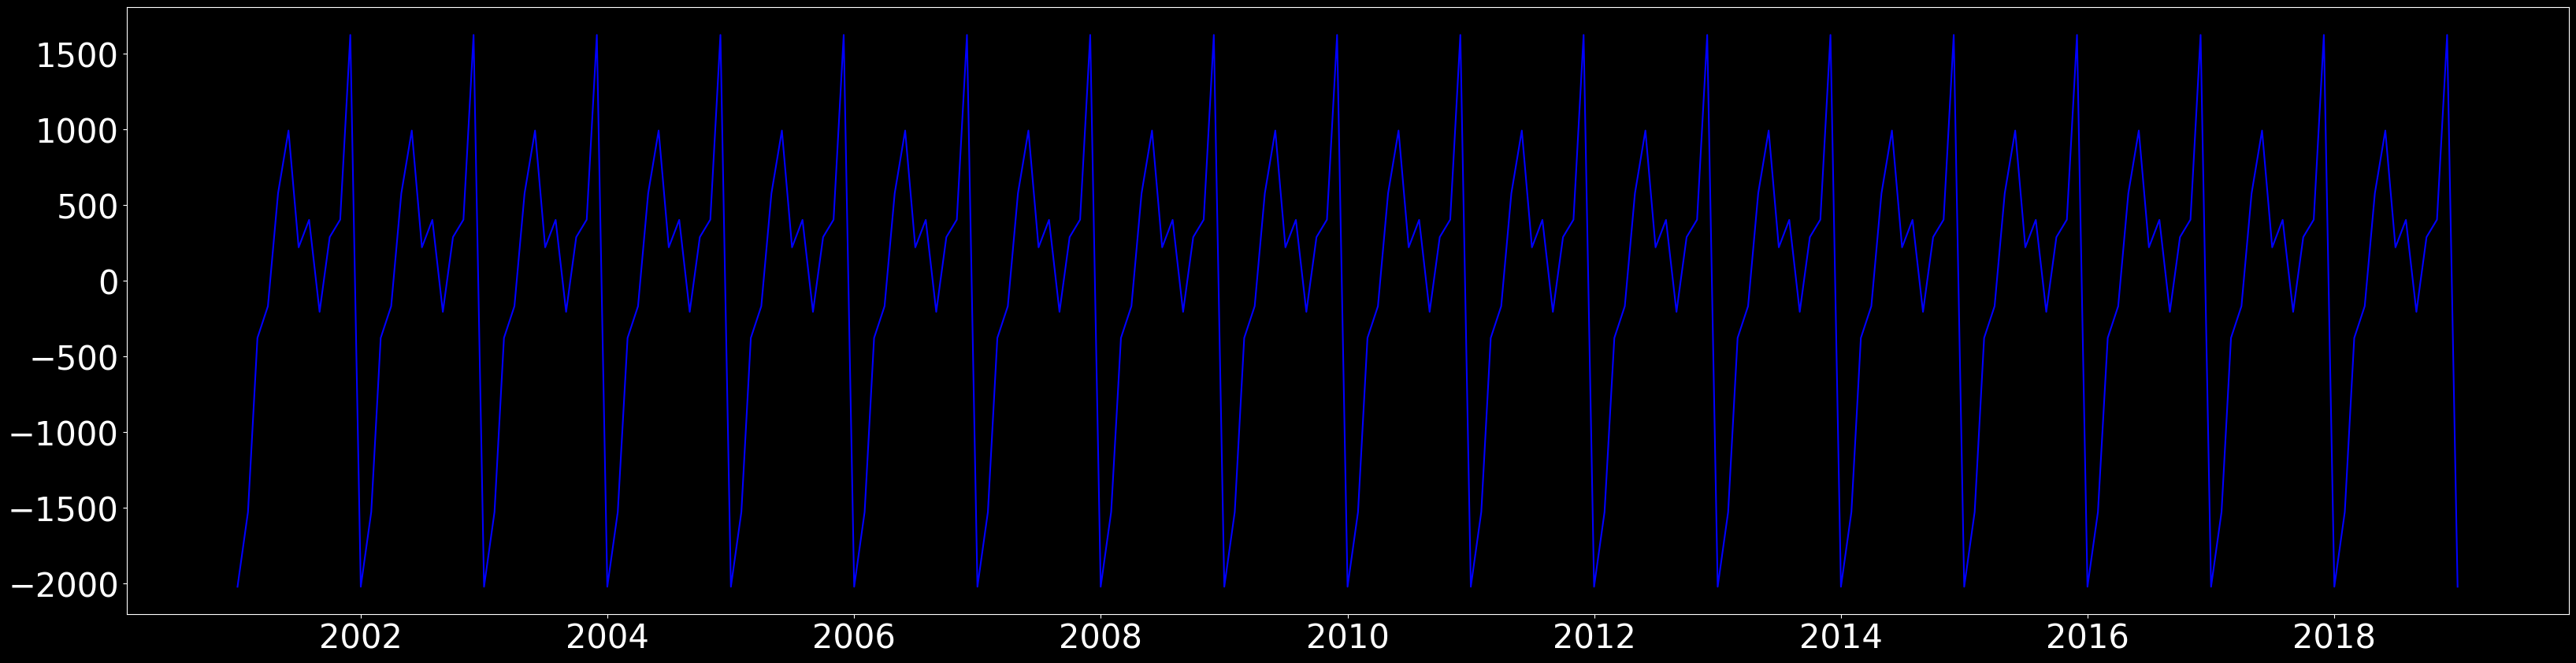

In [366]:
plt.plot(dtdf.date , dtdf.groupby(dtdf.date.dt.month)['sales'].transform('mean'))

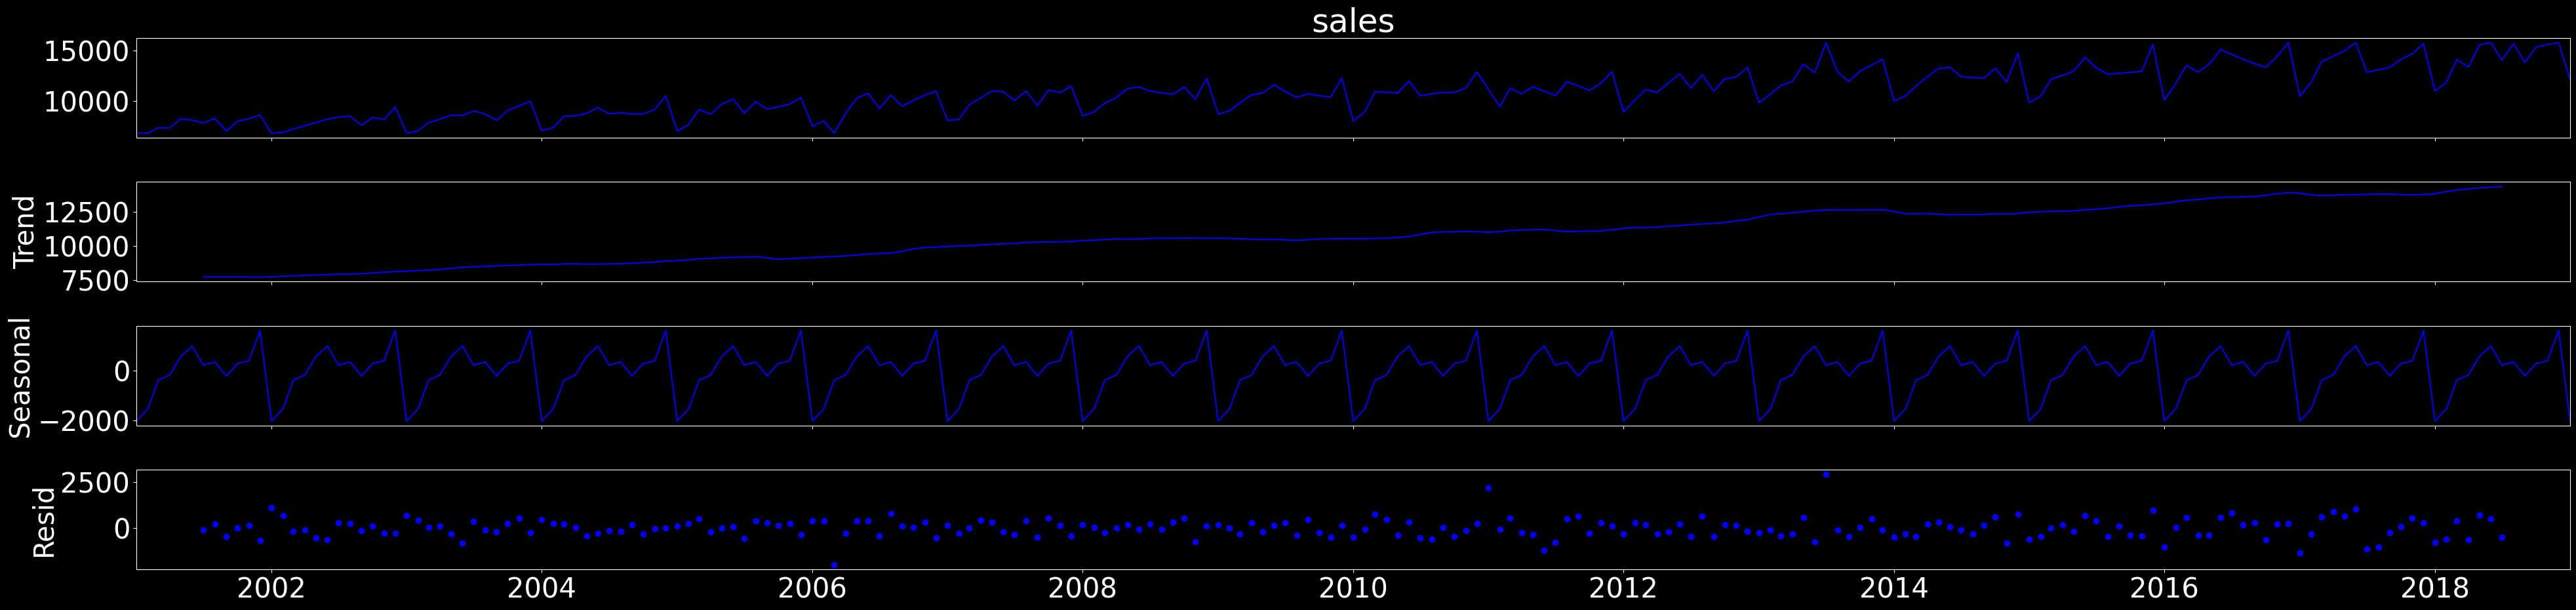

In [367]:
import statsmodels.api as sm
model = sm.tsa.seasonal_decompose(df.sales , model = 'additive')
model.plot();

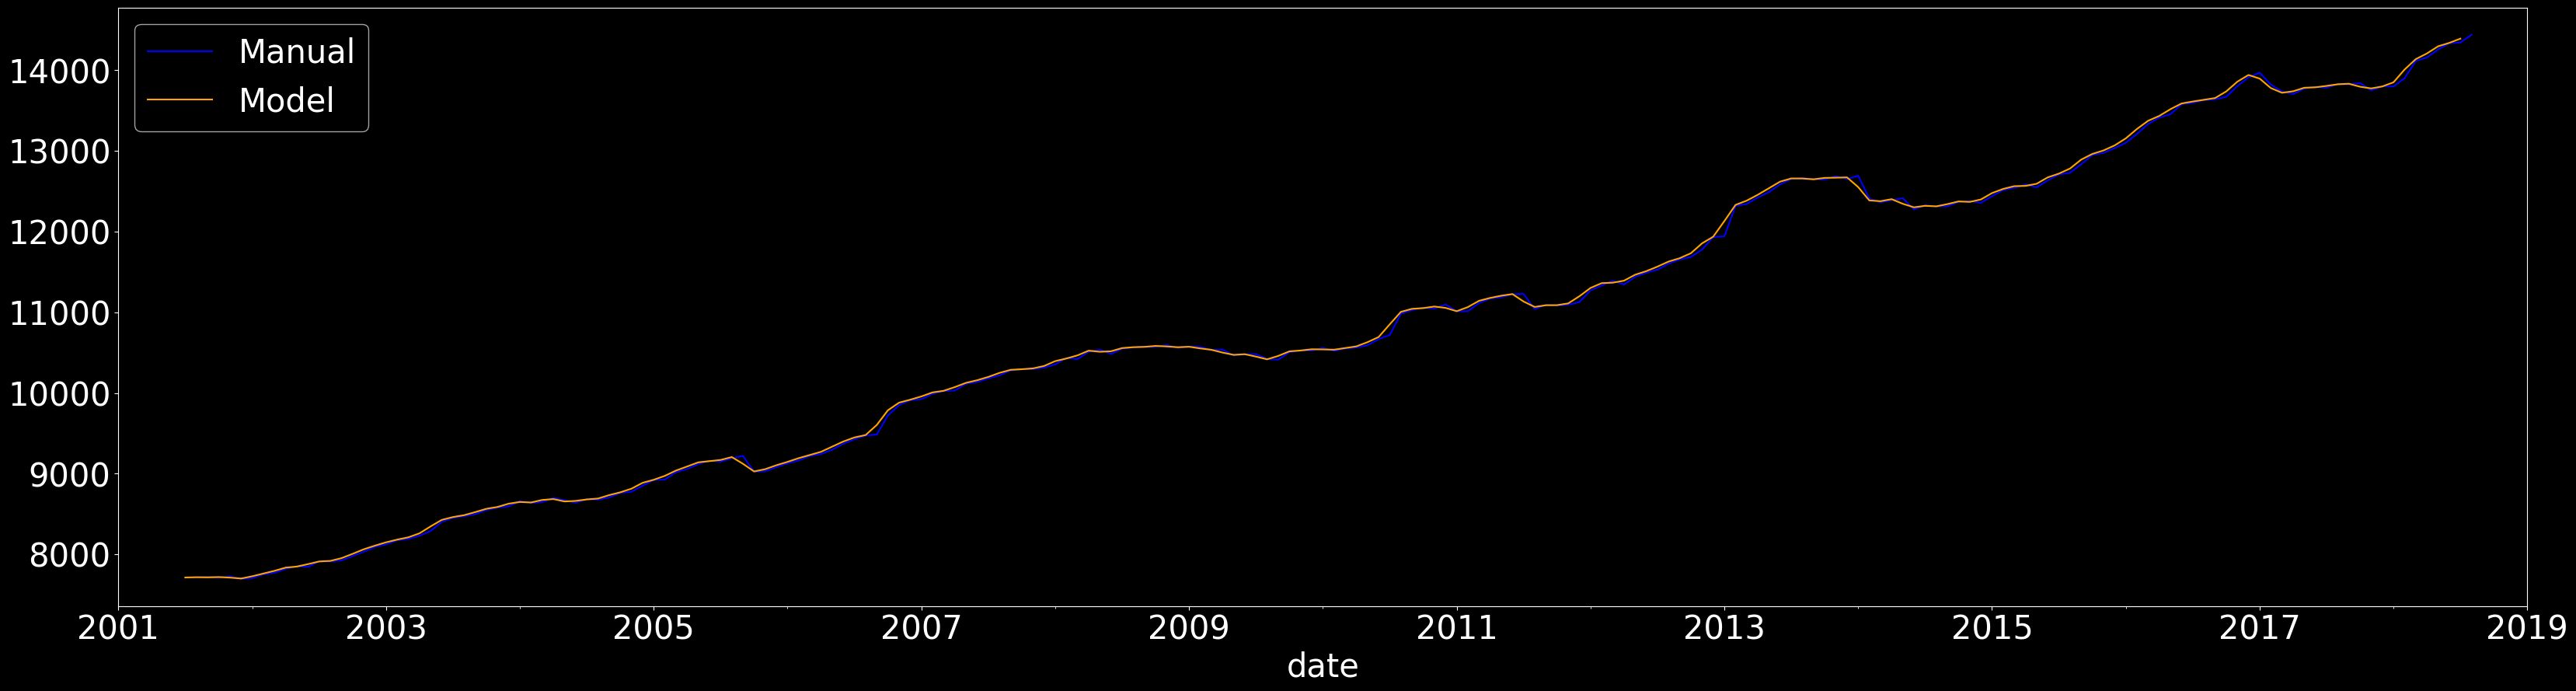

In [368]:
trend.plot(label = 'Manual')
model.trend.plot(label = 'Model')
plt.legend()

# Forcasting:


In [369]:
from sklearn.metrics import (mean_squared_error as mse , mean_absolute_error as mae , mean_absolute_percentage_error as mape)

def performance(actual , predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

In [370]:
# split the data into train and test:
trainx = df[df.index < df.index[-12]].copy()
testx = df[df.index >= df.index[-12]].copy()
testx

,sales
date,
2018-02-01,11852.0
2018-03-01,14123.0
2018-04-01,13360.0
2018-05-01,15576.0
2018-06-01,15809.4
2018-07-01,14080.0
2018-08-01,15697.0
2018-09-01,13838.0
2018-10-01,15351.0


In [371]:
# forcasting the mean as perdiction:
performance(testx.sales , [trainx.sales.mean() for i in testx.index])

MAE : 3786.031
RMSE : 4025.906
MAPE: 0.255


<Axes: xlabel='date'>

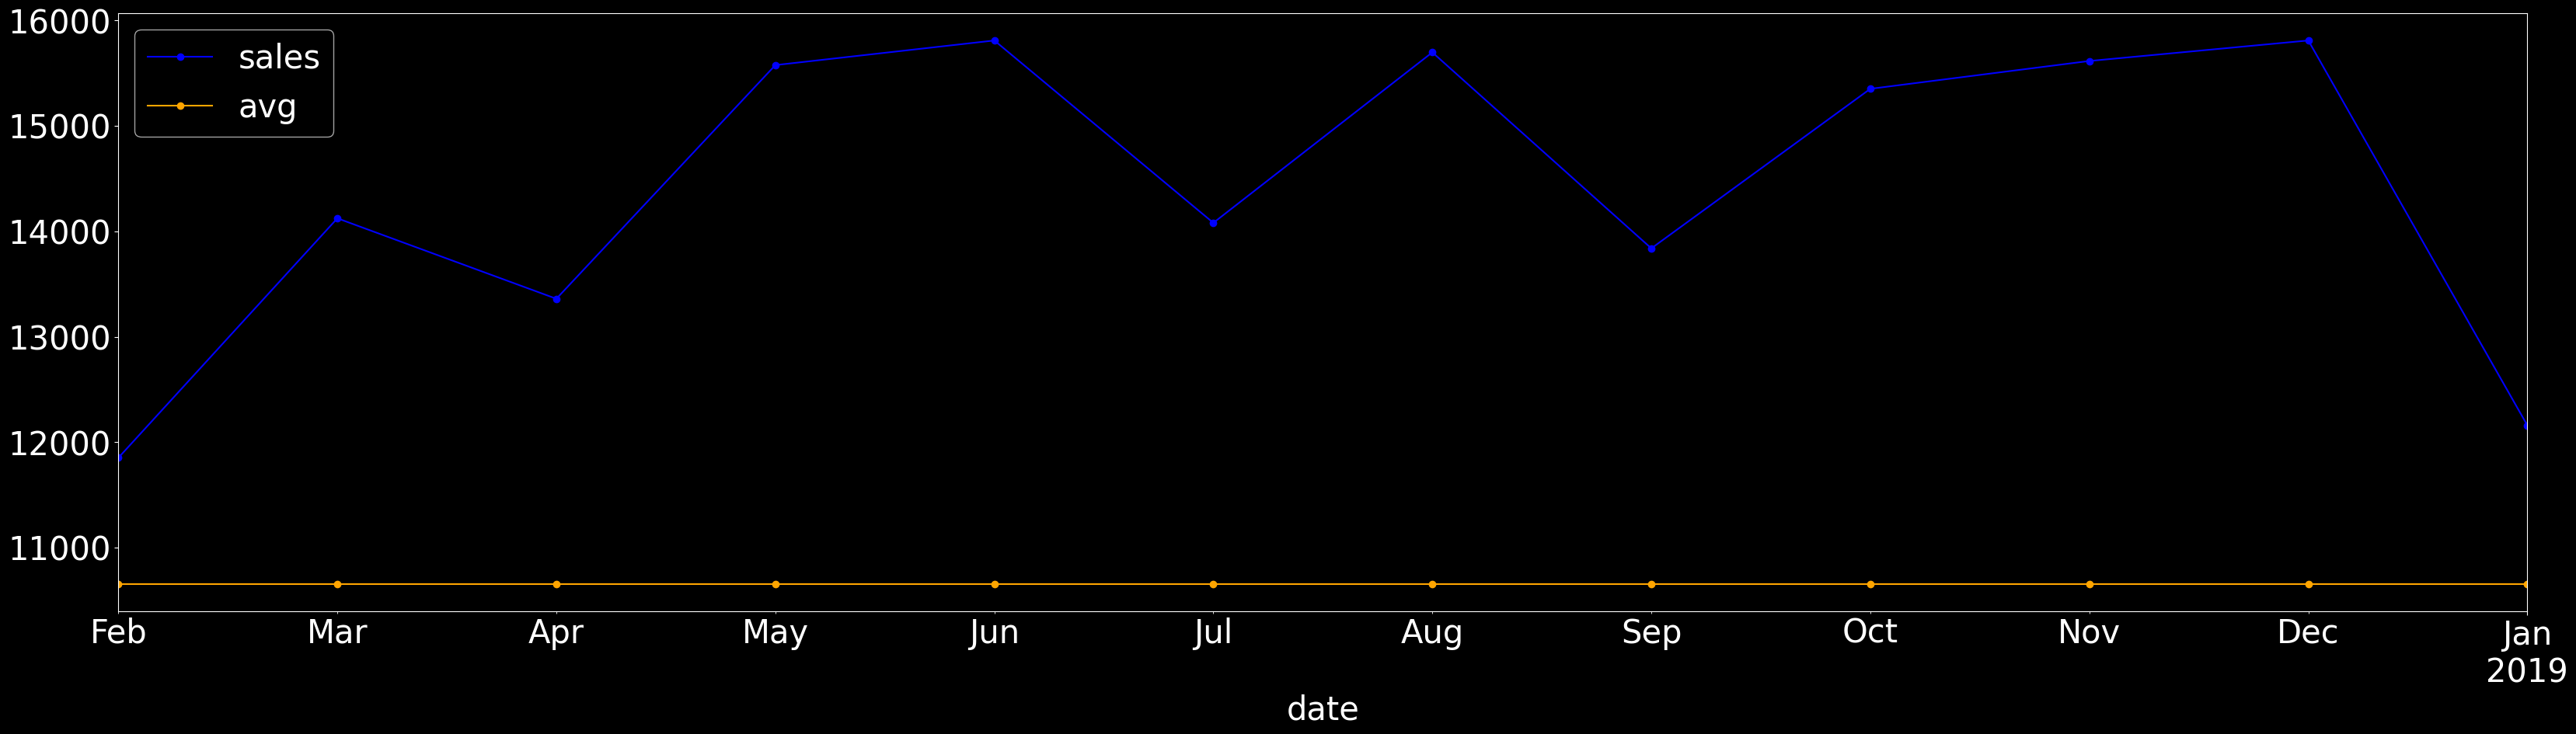

In [372]:
testx['avg'] = trainx.sales.mean()
testx.plot(style = '-o')

MAE : 3434.233
RMSE : 3697.005
MAPE: 0.23


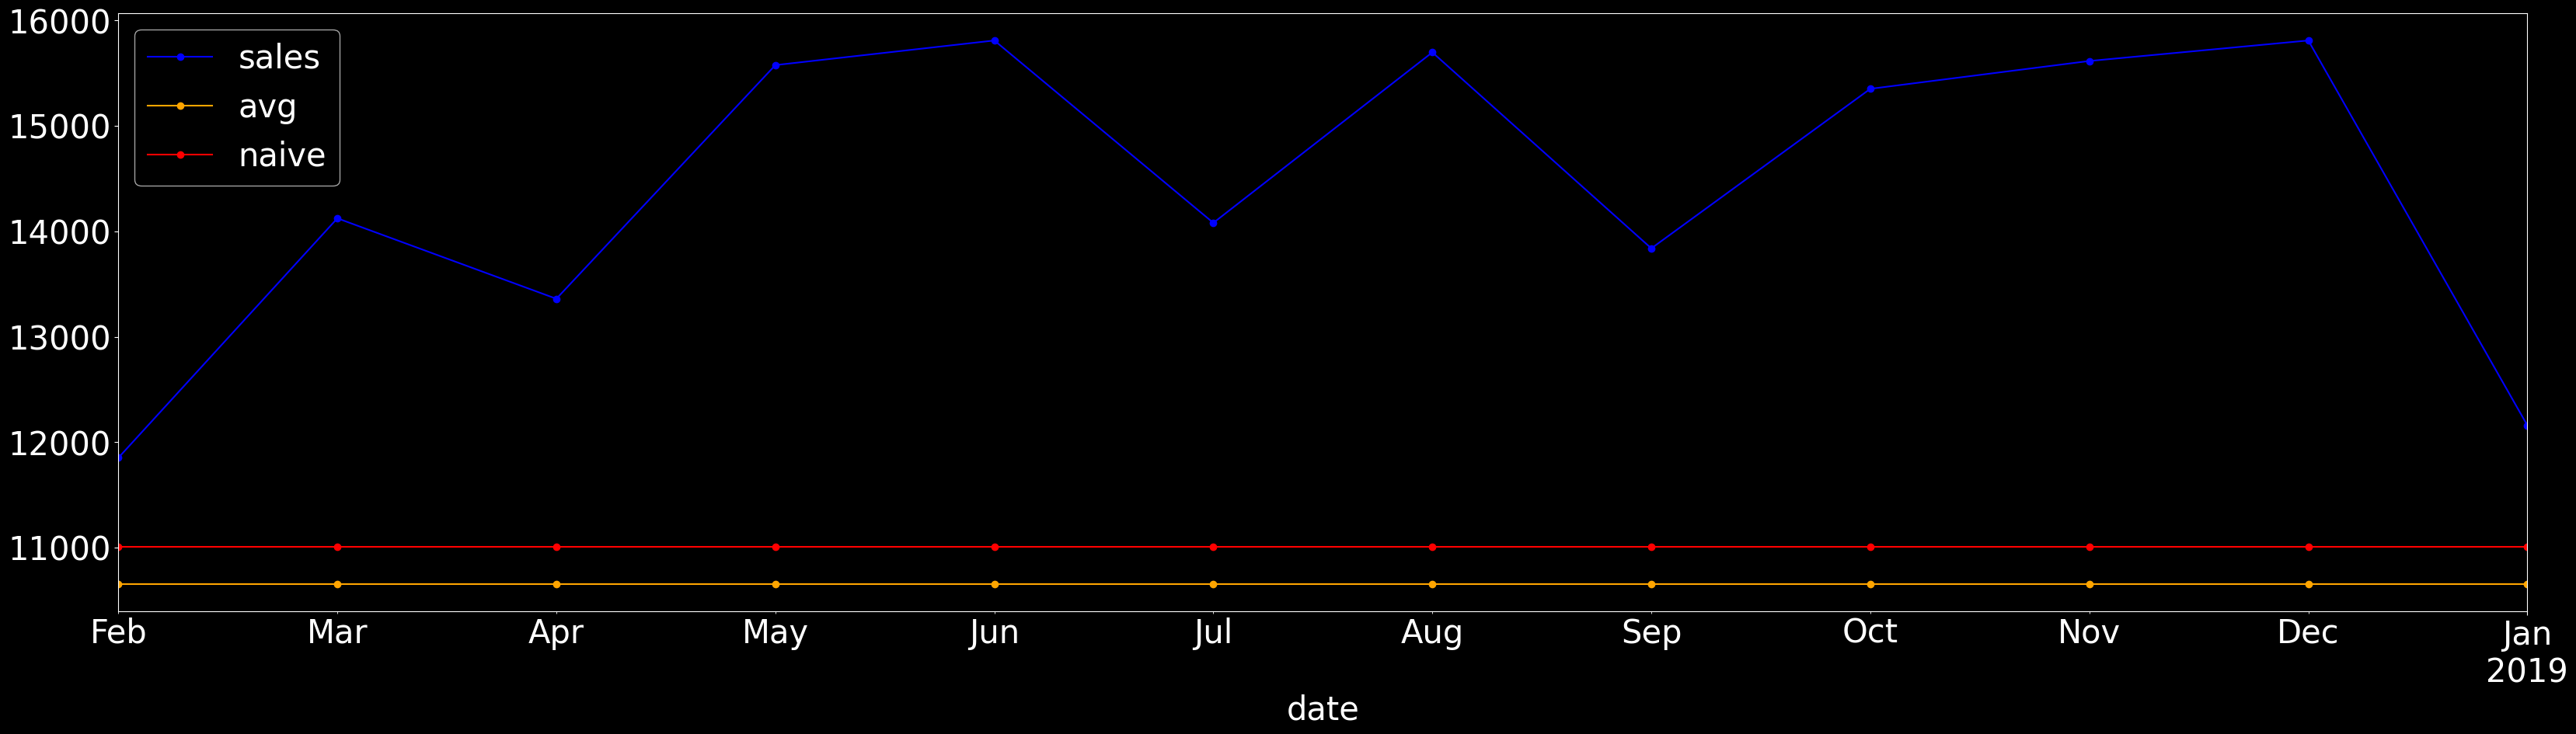

In [373]:
# naive mathod:
testx['naive'] = trainx.sales.iloc[-1]
testx.plot(style = '-o')
performance(testx.sales , testx['naive'])

<Axes: xlabel='date'>

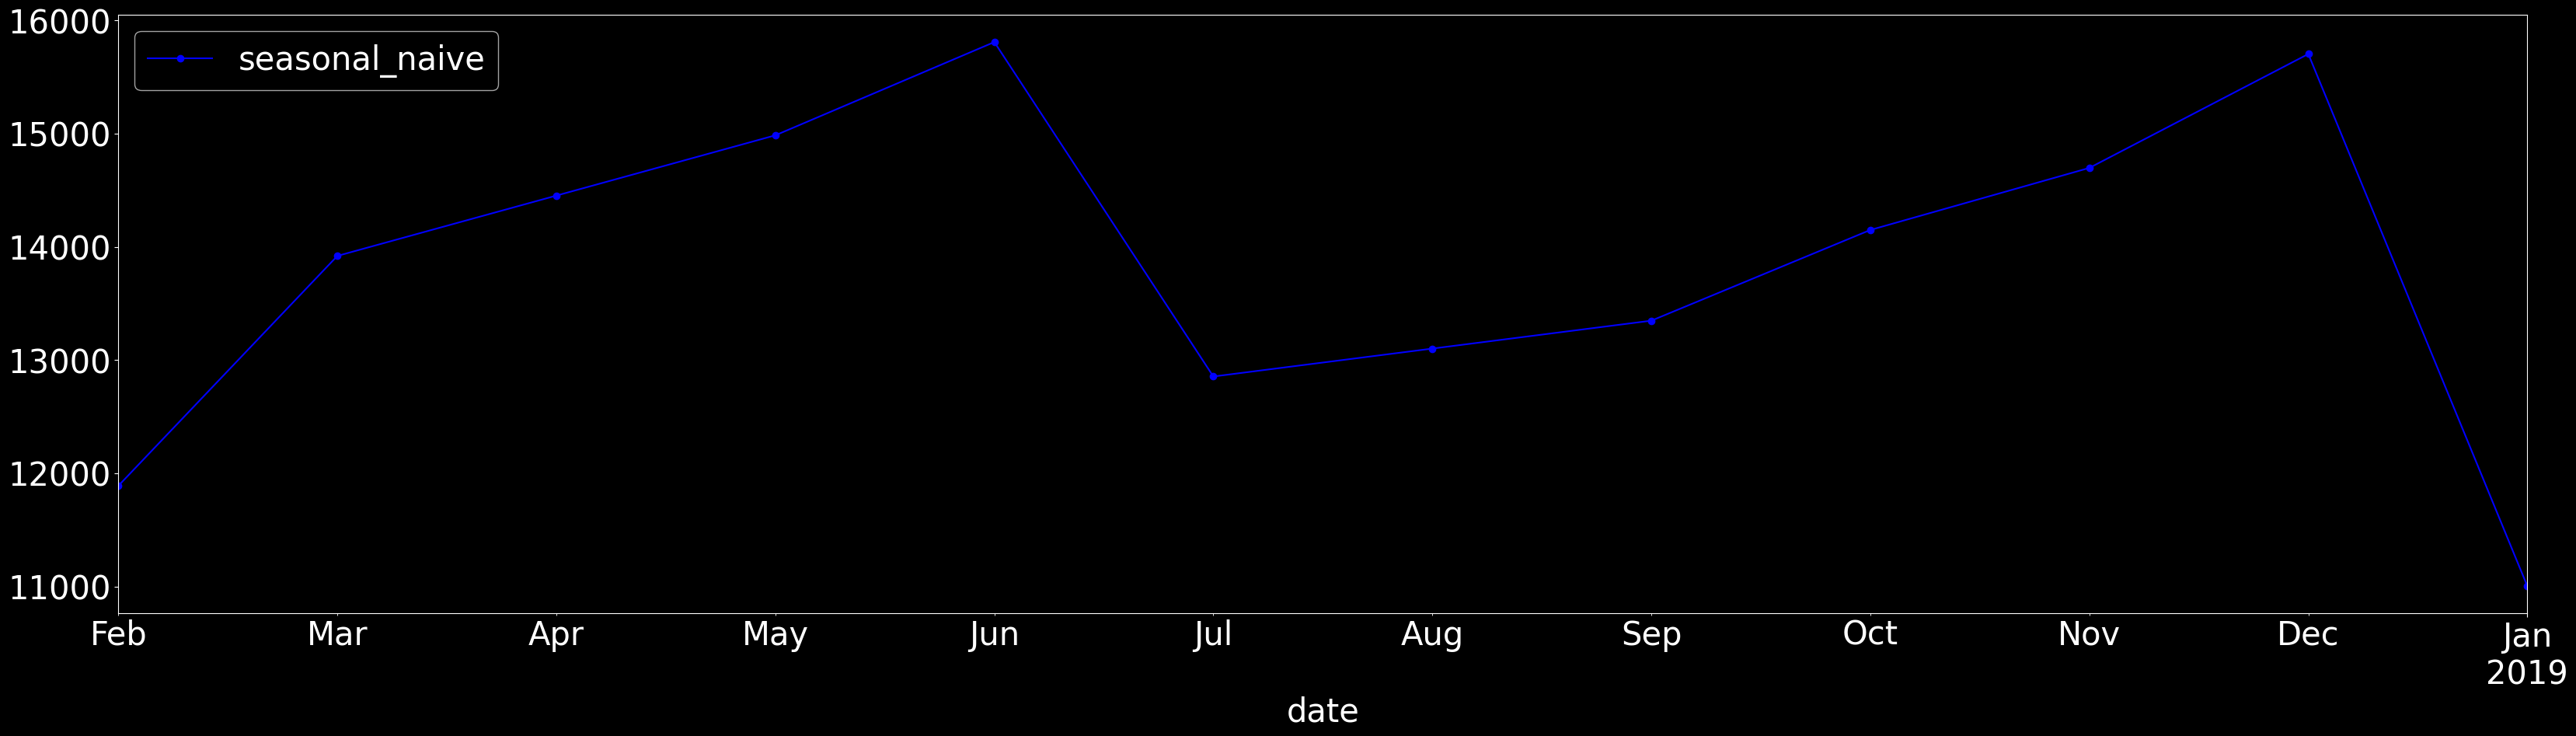

In [374]:
# Seasonal Naive:

testx['seasonal_naive'] = trainx.sales.reindex(testx.index - pd.DateOffset(years = 1)).values
testx[['seasonal_naive']].plot(style = '-o')
# performance(testx.sales , testx['seasonal_naive'])

/var/folders/5f/scjcfk_97_n7zmjltnpm2mjc0000gn/T/ipykernel_65484/3374980667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testx.loc[i]['seasonal_naive'] = trainx.loc[i - pd.DateOffset(years=1)]['sales']


MAE : 800.867
RMSE : 1067.837
MAPE: 0.055


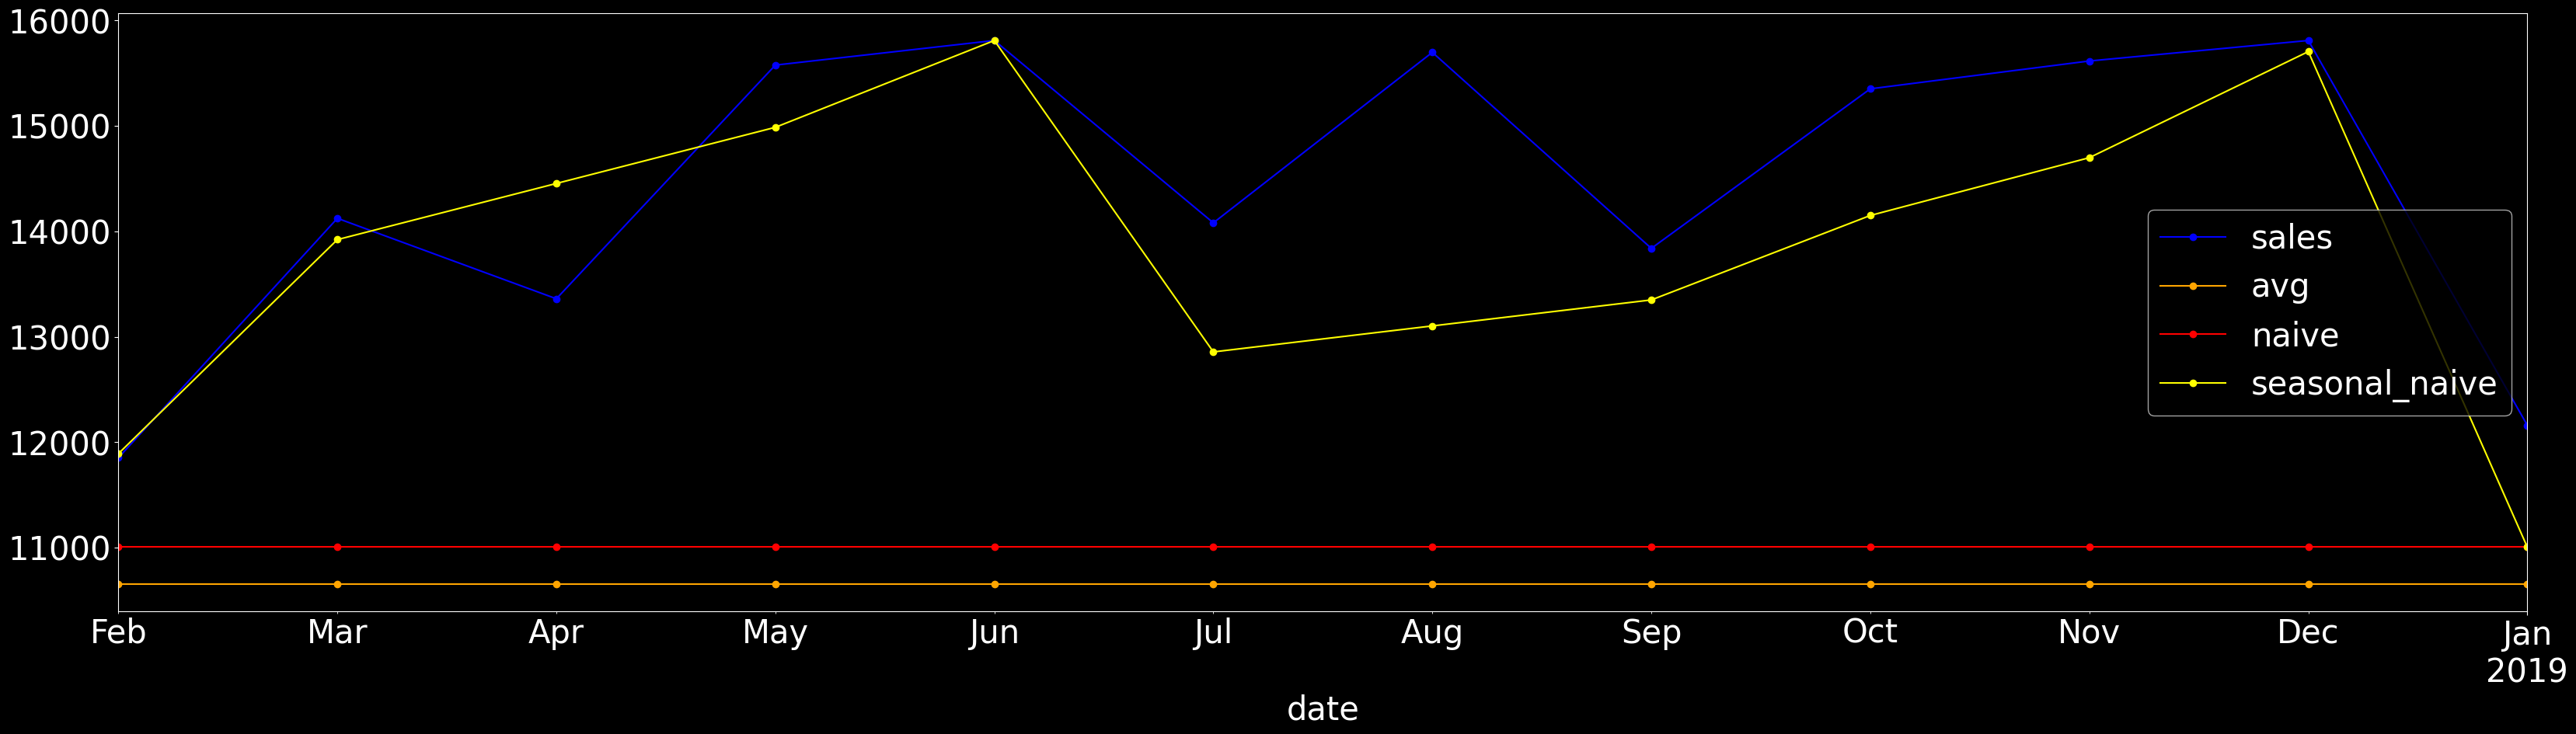

In [375]:
for i in testx.index:
  testx.loc[i]['seasonal_naive'] = trainx.loc[i - pd.DateOffset(years=1)]['sales']

testx.plot(style='-o')

performance(testx['sales'], testx['seasonal_naive'])

/var/folders/5f/scjcfk_97_n7zmjltnpm2mjc0000gn/T/ipykernel_65484/88060147.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m = (trainx.sales[-1] - trainx.sales[0])/ trainx.shape[0]


MAE : 3321.482
RMSE : 3586.323
MAPE: 0.223


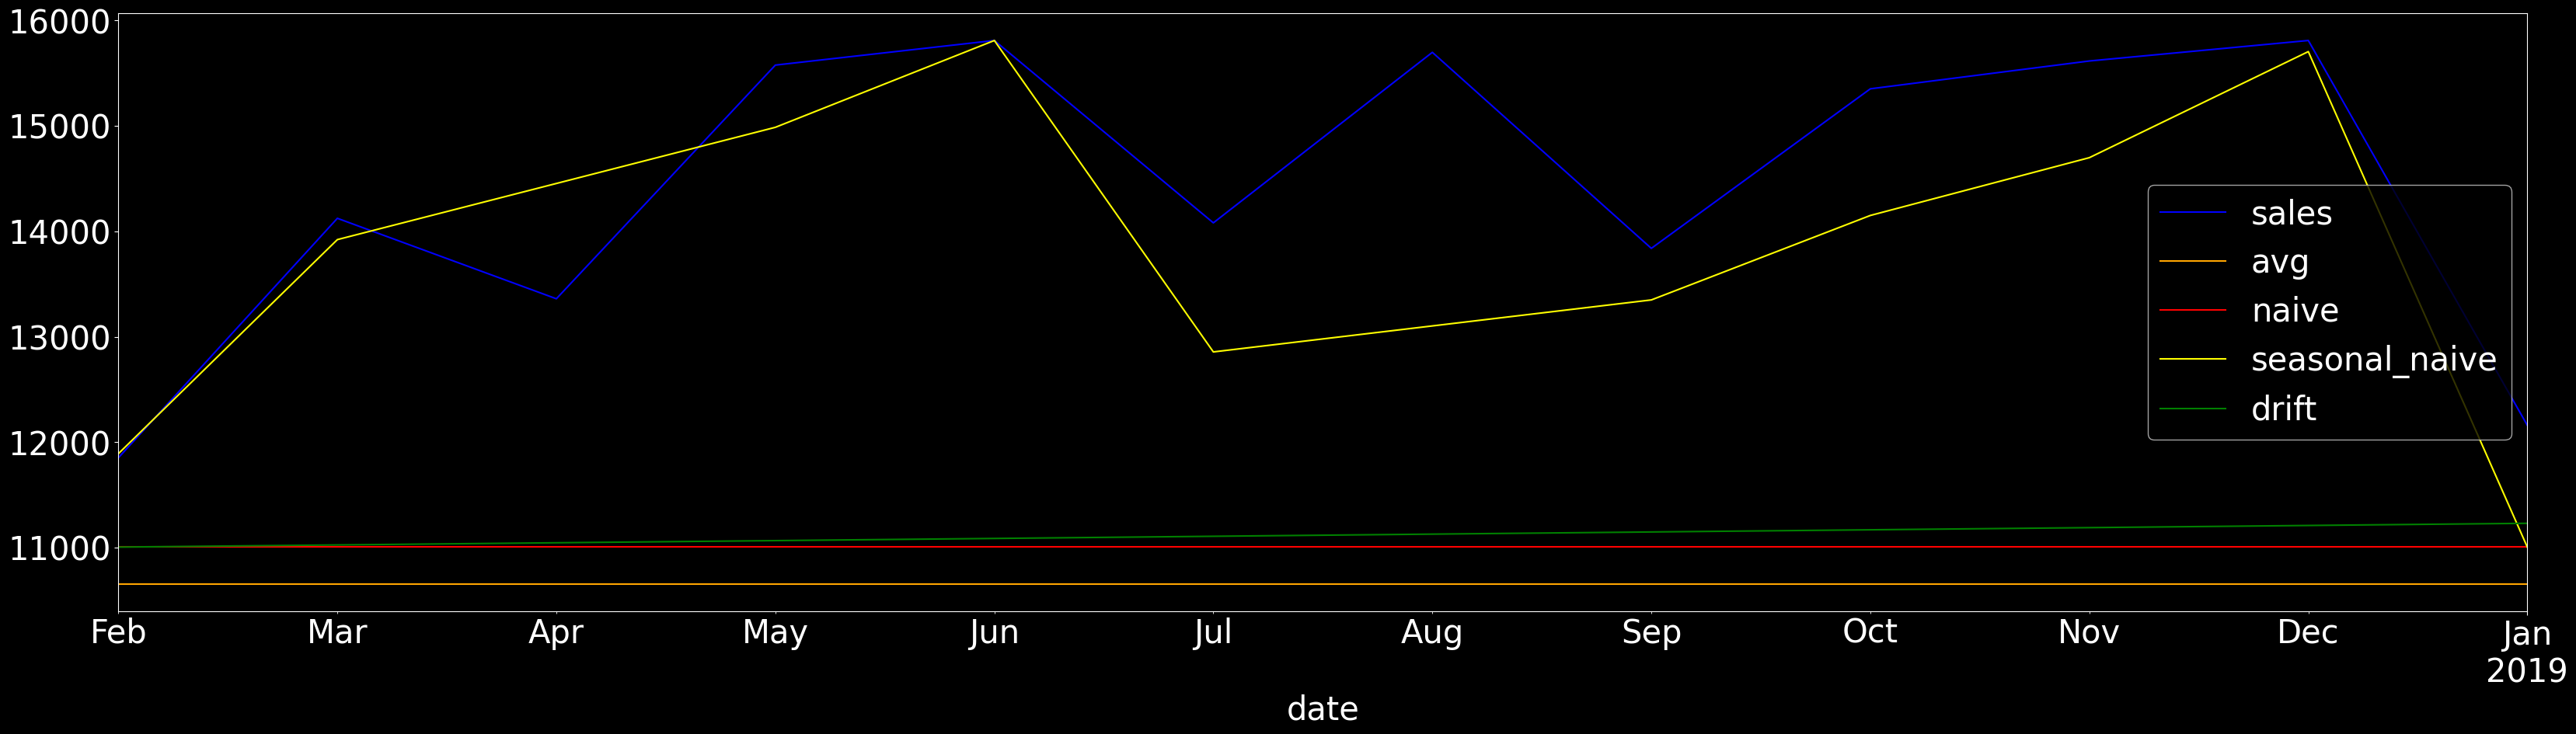

In [376]:
# drift method:
m = (trainx.sales[-1] - trainx.sales[0])/ trainx.shape[0]
h = np.linspace(0 , len(testx) - 1 , len(testx))
testx['drift'] = trainx.sales.iloc[-1] + m * h

testx.plot()
performance(testx.sales , testx.drift)

## Smoothing based forcasting methods:


In [377]:
test = pd.DataFrame(testx['sales'].copy())
test

,sales
date,
2018-02-01,11852.0
2018-03-01,14123.0
2018-04-01,13360.0
2018-05-01,15576.0
2018-06-01,15809.4
2018-07-01,14080.0
2018-08-01,15697.0
2018-09-01,13838.0
2018-10-01,15351.0


In [ ]:
# test = pd.concat( [test , pd.DataFrame(index = pd.date_range(start = testx.index[-1] , periods= 13 , freq = 'MS')[1:])] )
test

,sales
2018-02-01,11852.0
2018-03-01,14123.0
2018-04-01,13360.0
2018-05-01,15576.0
2018-06-01,15809.4
2018-07-01,14080.0
2018-08-01,15697.0
2018-09-01,13838.0
2018-10-01,15351.0
2018-11-01,15615.0


<Axes: xlabel='date'>

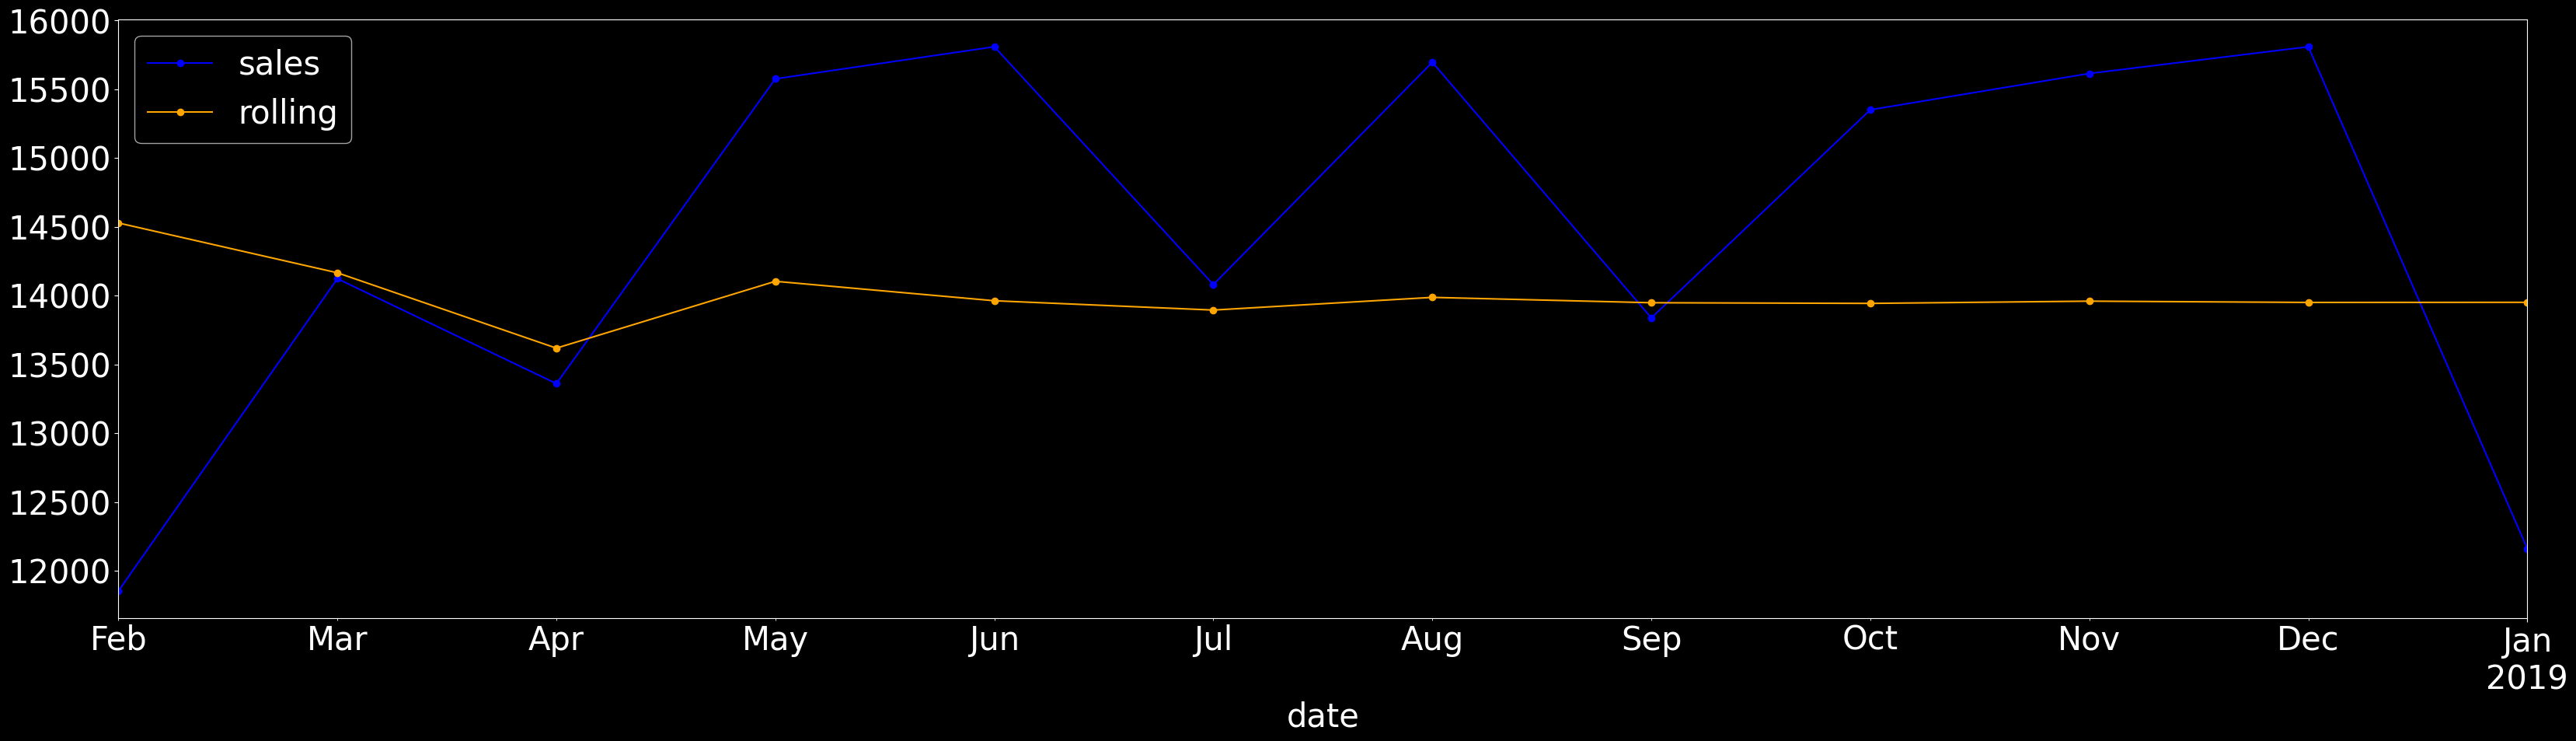

In [380]:
pred = test.sales.dropna().values
for i in range(12):
    pred = np.append(pred , pred[-3:].mean())

test['rolling'] = pred[-12:]
test.plot(style = '-o')

In [353]:
test

,sales,rolling
2018-02-01,11852.0,11852.000000
2018-03-01,14123.0,14123.000000
2018-04-01,13360.0,13360.000000
2018-05-01,15576.0,15576.000000
2018-06-01,15809.4,15809.400000
2018-07-01,14080.0,14080.000000
2018-08-01,15697.0,15697.000000
2018-09-01,13838.0,13838.000000
2018-10-01,15351.0,15351.000000
2018-11-01,15615.0,15615.000000
